### Imports

In [1]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

### Load constants

In [2]:
from const import *

## Train data augmentation

In [3]:
TRAIN_TRANSFORM = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) if IMAGE_TYPE['no_channels'] == 3 else transforms.Normalize(mean=[0.5], std=[0.5])
])

In [4]:
class WaldoImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(IMAGE_EXTENSION)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        match IMAGE_TYPE['no_channels']:
            case 1:
                image = Image.open(img_path).convert("L")  # Grayscale
            case 3:
                image = Image.open(img_path).convert("RGB")  # RGB
            case _:
                raise ValueError("Unsupported number of channels")
        
        if self.transform:
            image = self.transform(image)
        
        return image, image

def get_dataloaders(root_dir, transform, batch_size):
    dataset = WaldoImageDataset(root_dir=root_dir, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
from models import (
    ThreePoolLayerConvAutoencoder,
    ShallowConvAutoencoder,
    UNetAutoencoder
)

Model = UNetAutoencoder

In [6]:
BATCH_SIZE: int = 64
LEARNING_RATE: float = 1e-3
NUM_EPOCHS: int = 100
NOISE_FACTOR: float = 0.1
WEIGHT_DECAY: float = 5e-5

In [7]:
def add_gaussian_noise(images, noise_factor):
    noisy_images = images + noise_factor * torch.randn_like(images)
    noisy_images = torch.clamp(noisy_images, -1., 1.)
    return noisy_images

In [8]:
def train(model, data_root, transform, epochs, device):
    dataset = WaldoImageDataset(root_dir=data_root, transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    model.to(device)

    for epoch in range(epochs):
        for images in dataloader:
            if isinstance(images, (list, tuple)):
                images = images[0]
            clean_images = images.to(device)

            noisy_images = add_gaussian_noise(clean_images.clone(), NOISE_FACTOR)
            optimizer.zero_grad()
            outputs = model(noisy_images)
            loss = criterion(outputs, clean_images)
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    print("Training complete.")
    return model

In [9]:
trained_model = train(Model(latent_dim=IMAGE_SIZE//4, image_size=IMAGE_SIZE, channels=IMAGE_TYPE['no_channels']), 
                      TRAIN_DATA_PATH, TRAIN_TRANSFORM, NUM_EPOCHS, DEVICE)

Epoch [1/100], Loss: 0.4309
Epoch [2/100], Loss: 0.3928
Epoch [3/100], Loss: 0.4247
Epoch [4/100], Loss: 0.3455
Epoch [5/100], Loss: 0.3321
Epoch [6/100], Loss: 0.3163
Epoch [7/100], Loss: 0.2980
Epoch [8/100], Loss: 0.3062
Epoch [9/100], Loss: 0.2693
Epoch [10/100], Loss: 0.2651
Epoch [11/100], Loss: 0.2727
Epoch [12/100], Loss: 0.2708
Epoch [13/100], Loss: 0.2809
Epoch [14/100], Loss: 0.2763
Epoch [15/100], Loss: 0.2647
Epoch [16/100], Loss: 0.2741
Epoch [17/100], Loss: 0.2693
Epoch [18/100], Loss: 0.2603
Epoch [19/100], Loss: 0.2768
Epoch [20/100], Loss: 0.2440
Epoch [21/100], Loss: 0.2687
Epoch [22/100], Loss: 0.2487
Epoch [23/100], Loss: 0.2404
Epoch [24/100], Loss: 0.2388
Epoch [25/100], Loss: 0.2366
Epoch [26/100], Loss: 0.2509
Epoch [27/100], Loss: 0.2160
Epoch [28/100], Loss: 0.2353
Epoch [29/100], Loss: 0.2229
Epoch [30/100], Loss: 0.2611
Epoch [31/100], Loss: 0.2326
Epoch [32/100], Loss: 0.2533
Epoch [33/100], Loss: 0.2146
Epoch [34/100], Loss: 0.2423
Epoch [35/100], Loss: 0

## Test data preparations

In [10]:
TEST_TRANSFORM = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) if IMAGE_TYPE['no_channels'] == 3 else transforms.Normalize(mean=[0.5], std=[0.5])
])

In [11]:
def get_test_dataloaders(normal_path, anomaly_path, transform, batch_size):
    normal_dataset = WaldoImageDataset(root_dir=normal_path, transform=transform)
    normal_loader = DataLoader(normal_dataset, batch_size=batch_size, shuffle=False)
    
    anomaly_dataset = WaldoImageDataset(root_dir=anomaly_path, transform=transform)
    anomaly_loader = DataLoader(anomaly_dataset, batch_size=batch_size, shuffle=False)
    
    return normal_loader, anomaly_loader

In [12]:
def calculate_reconstruction_errors(model, dataloader, device):
    model.eval()
    all_errors = []
    
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            
            reconstructed = model(images)
            mse_loss = F.mse_loss(reconstructed, images, reduction='none')
            reconstruction_error = mse_loss.sum(dim=[1, 2, 3]) 
            
            all_errors.extend(reconstruction_error.cpu().numpy())
            
    return np.array(all_errors)

Normal Errors Stats: Mean=7858.3403, Std=2381.2952, Max=13959.1309
Anomaly Errors Stats: Mean=14602.7871, Std=3495.2969, Min=8779.3154


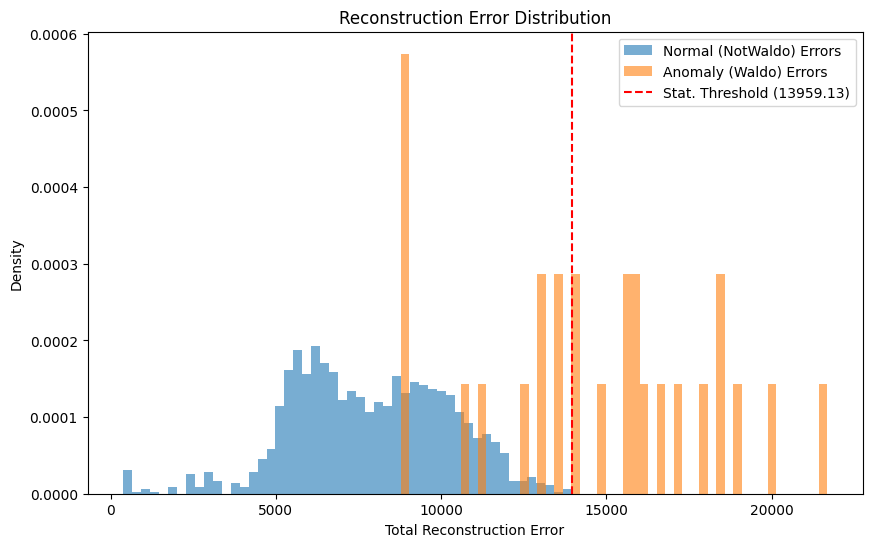


--- Model Performance (Using Logistic Regression Threshold) ---
AUC-ROC Score: 0.9366 (Closer to 1.0 is better)
F1 Score: 0.2136

Confusion Matrix:
[[1160  157]
 [   5   22]]
True Positives (Correct Waldo patches): 22
False Positives (NotWaldo flagged as Waldo): 157
False Negatives (Waldo missed): 5
True Negatives (Correct NotWaldo patches): 1160


In [13]:
from scipy.stats import scoreatpercentile
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def evaluate_model(model, normal_loader, anomaly_loader, device):
    # Calculate errors for both classes
    normal_errors = calculate_reconstruction_errors(model, normal_loader, device)
    print(f"Normal Errors Stats: Mean={np.mean(normal_errors):.4f}, Std={np.std(normal_errors):.4f}, Max={np.max(normal_errors):.4f}")
    THRESHOLD = scoreatpercentile(normal_errors, 100)
    anomaly_errors = calculate_reconstruction_errors(model, anomaly_loader, device)
    print(f"Anomaly Errors Stats: Mean={np.mean(anomaly_errors):.4f}, Std={np.std(anomaly_errors):.4f}, Min={np.min(anomaly_errors):.4f}")
    
    # Concatenate all errors and create true labels
    all_errors = np.concatenate([normal_errors, anomaly_errors])
    # True labels: 0 for normal, 1 for anomaly
    true_labels = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(anomaly_errors))])
    
    X = all_errors.reshape(-1, 1)
    y = true_labels

    # Scale the errors (recommended for Logistic Regression)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train the model (using the full test set as the final evaluation is based on it)
    log_reg = LogisticRegression(class_weight='balanced', solver='liblinear')
    log_reg.fit(X_scaled, y)
    
    # Predict using the Logistic Regression model
    predicted_labels = log_reg.predict(X_scaled)

    # --- 3. PLOT ERROR DISTRIBUTIONS ---
    plt.figure(figsize=(10, 6))
    plt.hist(normal_errors, bins=50, alpha=0.6, label='Normal (NotWaldo) Errors', density=True)
    plt.hist(anomaly_errors, bins=50, alpha=0.6, label='Anomaly (Waldo) Errors', density=True)
    plt.axvline(x=THRESHOLD, color='r', linestyle='--', label=f'Stat. Threshold ({THRESHOLD:.2f})')
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Total Reconstruction Error')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # --- 4. METRICS ---
    
    # 1. AUC-ROC Score
    auc_roc = roc_auc_score(true_labels, all_errors)
    
    # 2. Confusion Matrix using Logistic Regression predictions
    cm = confusion_matrix(true_labels, predicted_labels)
    tn, fp, fn, tp = cm.ravel()
    
    # 3. F1 Score
    f1 = f1_score(true_labels, predicted_labels)
    
    print("\n--- Model Performance (Using Logistic Regression Threshold) ---")
    print(f"AUC-ROC Score: {auc_roc:.4f} (Closer to 1.0 is better)")
    print(f"F1 Score: {f1:.4f}")
    print(f"\nConfusion Matrix:\n{cm}")
    print(f"True Positives (Correct Waldo patches): {tp}")
    print(f"False Positives (NotWaldo flagged as Waldo): {fp}")
    print(f"False Negatives (Waldo missed): {fn}")
    print(f"True Negatives (Correct NotWaldo patches): {tn}")

normal_test_loader, anomaly_test_loader = get_test_dataloaders(
    TRAIN_DATA_PATH, 
    TEST_DATA_PATH, 
    TEST_TRANSFORM, 
    BATCH_SIZE
)


evaluate_model(trained_model, normal_test_loader, anomaly_test_loader, DEVICE)